In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

import matplotx
import numpy as np
import pandas as pd

from scipy.stats import sem

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
all_res = glob("out/**/*.pkl")

In [4]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [5]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [6]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std", sem]
)

In [7]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std", sem])

In [8]:
compiled_grouped_res

mae                     max_error  \
                                     mean       std       sem      mean   
representation num_train_points                                           
InChI          10                2.590600  0.606471       NaN  7.880000   
               50                2.419744  0.186182  0.083263  7.872000   
               100               2.296072  0.159767  0.071450  8.150000   
               200               2.171624  0.141248  0.063168  7.624000   
               500               2.048170  0.047283  0.023641  7.425000   
SELFIES        10                1.995320       NaN       NaN  6.790000   
               50                2.270780  0.070047  0.028597  8.048333   
               100               2.328747  0.161490  0.065928  8.460000   
               200               2.246552  0.019912  0.008905  8.268000   
               500               2.153880  0.083308  0.037256  8.038000   
SMILES         10                2.490267  0.389636       NaN  7.413333   
               50                2.468225  0.262436       NaN  7.958750   
               100               2.360893  0.224988       NaN  7.924444   
               200               2.117711  0.070789  0.023596  8.033333   
               500               1.990114  0.100678  0.038053  7.135714   

                                                          mse            \
                                      std       sem      mean       std   
representation num_train_points                                           
InChI          10                1.173797       NaN  9.717969  4.439513   
               50                0.648591  0.290059  8.729042  1.241121   
               100               0.586686  0.262374  8.192075  1.147401   
               200               0.908532  0.406308  7.355268  1.128255   
               500               0.765485  0.382742  6.682002  0.483866   
SELFIES        10                     NaN       NaN  6.026665       NaN   
               50                0.497209  0.202985  7.925279  0.665553   
               100               0.285867  0.116705  8.468544  1.310805   
               200               0.520452  0.232753  7.856587  0.195403   
               500               0.814844  0.364409  7.467592  0.425018   
SMILES         10                1.042617       NaN  9.119594  2.660080   
               50                1.270741       NaN  9.155260  1.885829   
               100               0.769807       NaN  8.502304  1.684312   
               200               0.504331  0.168110  7.049765  0.425937   
               500               0.704340  0.266216  6.388704  0.816250   

                                           
                                      sem  
representation num_train_points            
InChI          10                     NaN  
               50                0.555046  
               100               0.513133  
               200               0.504571  
               500               0.241933  
SELFIES        10                     NaN  
               50                0.271711  
               100               0.535134  
               200               0.087387  
               500               0.190074  
SMILES         10                     NaN  
               50                     NaN  
               100                    NaN  
               200               0.141979  
               500               0.308514

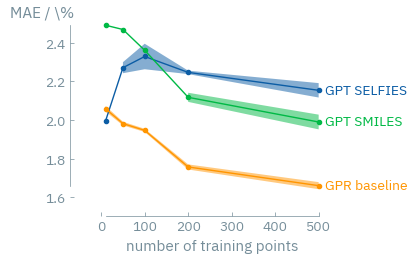

In [13]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1)
ax.plot(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"],
    label="GPT SELFIES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    alpha=.5
)

ax.plot(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"],
    label="GPT SMILES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="GPR baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["sem"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["sem"],
    alpha=0.5,
)

matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("MAE / \%", y_pad=-0.05, x_pad=0.02)
# ax.set_xscale('log')

range_frame(
    ax, 
     compiled_gpr_grouped.loc[:].index,
     np.nan_to_num(np.stack(
        [    compiled_gpr_grouped.loc[:]["mae"]["mean"], 
        compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
        ]
     ).flatten(), 1.7)
)

fig.savefig("opv_regression_res.pdf", bbox_inches="tight")